Adicionado rank_3                         com p-valor 0.006556
Adicionado rank_4                         com p-valor 0.008595

Variáveis selecionadas pelo método Stepwise:
['rank_3', 'rank_4']
Optimization terminated successfully.
         Current function value: 0.594052
         Iterations 5

Resumo do Modelo Final:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  280
Model:                          Logit   Df Residuals:                      277
Method:                           MLE   Df Model:                            2
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                 0.04568
Time:                        03:24:07   Log-Likelihood:                -166.33
converged:                       True   LL-Null:                       -174.30
Covariance Type:            nonrobust   LLR p-value:                 0.0003485
                 coef    std err          z     

/tmp/ipython-input-3765972548.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = f"logit(P) = {params[0]:.4f} "
/tmp/ipython-input-3765972548.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation += f"+ ({params[i]:.4f} * {params.index[i]}) "
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/skl

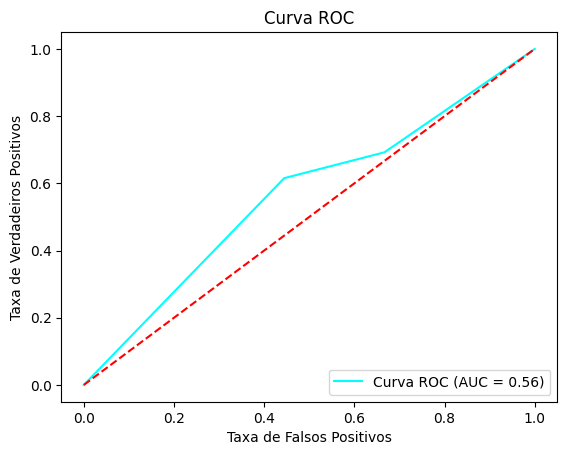

In [1]:
# Regressão Logística com Seleção Stepwise em Python

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Carregar o dataset
data = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

# Converter 'rank' para variável categórica e criar variáveis dummy
data['rank'] = data['rank'].astype('category')
data = pd.get_dummies(data, columns=['rank'], drop_first=True)

# Definir a variável alvo e as variáveis preditoras
target = 'admit'
features = data.columns.drop(target)
X = data[features]
y = data[target]

# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Converter colunas booleanas para inteiros
X_train = X_train.astype(int)
X_test = X_test.astype(int)

# Função de seleção stepwise
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Etapa forward
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Adicionado {best_feature:30} com p-valor {best_pval:.6f}')
        # Etapa backward
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Removido {worst_feature:30} com p-valor {worst_pval:.6f}')
        if not changed:
            break
    return included

# Aplicar a seleção stepwise
selected_features = stepwise_selection(X_train, y_train)
print("\nVariáveis selecionadas pelo método Stepwise:")
print(selected_features)

# Ajustar o modelo final com as variáveis selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model_final = sm.Logit(y_train, sm.add_constant(X_train_selected)).fit()

# Exibir o resumo do modelo final
print("\nResumo do Modelo Final:")
print(model_final.summary())

# Exibir a equação do modelo final
print("\nEquação do Modelo Final:")
params = model_final.params
equation = f"logit(P) = {params[0]:.4f} "
for i in range(1, len(params)):
    equation += f"+ ({params[i]:.4f} * {params.index[i]}) "
print(equation)

# Avaliar o modelo
# Prever probabilidades no conjunto de teste
y_pred_prob = model_final.predict(sm.add_constant(X_test_selected))
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("\nMatriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))

# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='cyan', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.style.use('dark_background')  # Tema dark mode
plt.show()